## Importing Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


## Loading Dataset

In [2]:
# Loading dataset
train = pd.read_csv(r'C:\Users\Ojas\Desktop\Mercari Price Suggestions\Mercari Price Suggestions\train.tsv', sep = '\t')
test = pd.read_csv(r'C:\Users\Ojas\Desktop\Mercari Price Suggestions\Mercari Price Suggestions\test.tsv', sep = '\t')

In [3]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
# Exploring Training dataset
print(train.dtypes)

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object


In [5]:
print("Training data size is: " + str(train.shape))

Training data size is: (1482535, 8)


There are total 1482535 observations in the training dataset.

##  Summary Statistics

In [6]:
train.astype('object').describe().transpose()

,count,unique,top,freq
train_id,1482535,1482535,1482534,1
name,1482535,1225273,Bundle,2232
item_condition_id,1482535,5,1,640549
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177
brand_name,849853,4809,PINK,54088
price,1.48254e+06,828,10,99416
shipping,1482535,2,0,819435
item_description,1482531,1281426,No description yet,82489


From the summary statistics we can observe that,
<ul>
<li>Most product prices are at $10</li>
<li>There are around 83000 items with no description</li>
<li>There are 4809 unique brands</li>
<li>There are majority of women's products</li></ul>

In [7]:
# Exploring testing data
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [8]:
print("Test data size is: " + str(test.shape))


Test data size is: (693359, 7)


There are around 700,000 observations in the test dataset.

## Decreasing size of Training DataSet

Sampling only 10% of the dataset now, to improve processing speed.

In [ ]:
decrease_train = train.sample(frac=0.1).reset_index(drop=True)
train= decrease_train

##  Data Cleaning 

In [10]:
train.isnull().sum()

train_id                 0
name                     0
item_condition_id        0
category_name          640
brand_name           62982
price                    0
shipping                 0
item_description         0
dtype: int64

Brand name and category name values are missing.

In [12]:
### Imputing missing values
def miss_val(data):
    data['category_name'].fillna(value = 'Other', inplace=True)
    data['brand_name'].fillna(value = 'Unknown', inplace=True)
    data['item_description'].fillna(value='No description available', inplace=True)
    return data

In [13]:
train = miss_val(train)
train.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

## Exploratory Data Analysis

### Observing the target feature (Price)

In [14]:
train['price'].describe()

count    148254.000000
mean         26.817792
std          37.934980
min           0.000000
25%          10.000000
50%          17.000000
75%          30.000000
max        2000.000000
Name: price, dtype: float64

Text(0.5, 1.0, 'Distribution of Price')

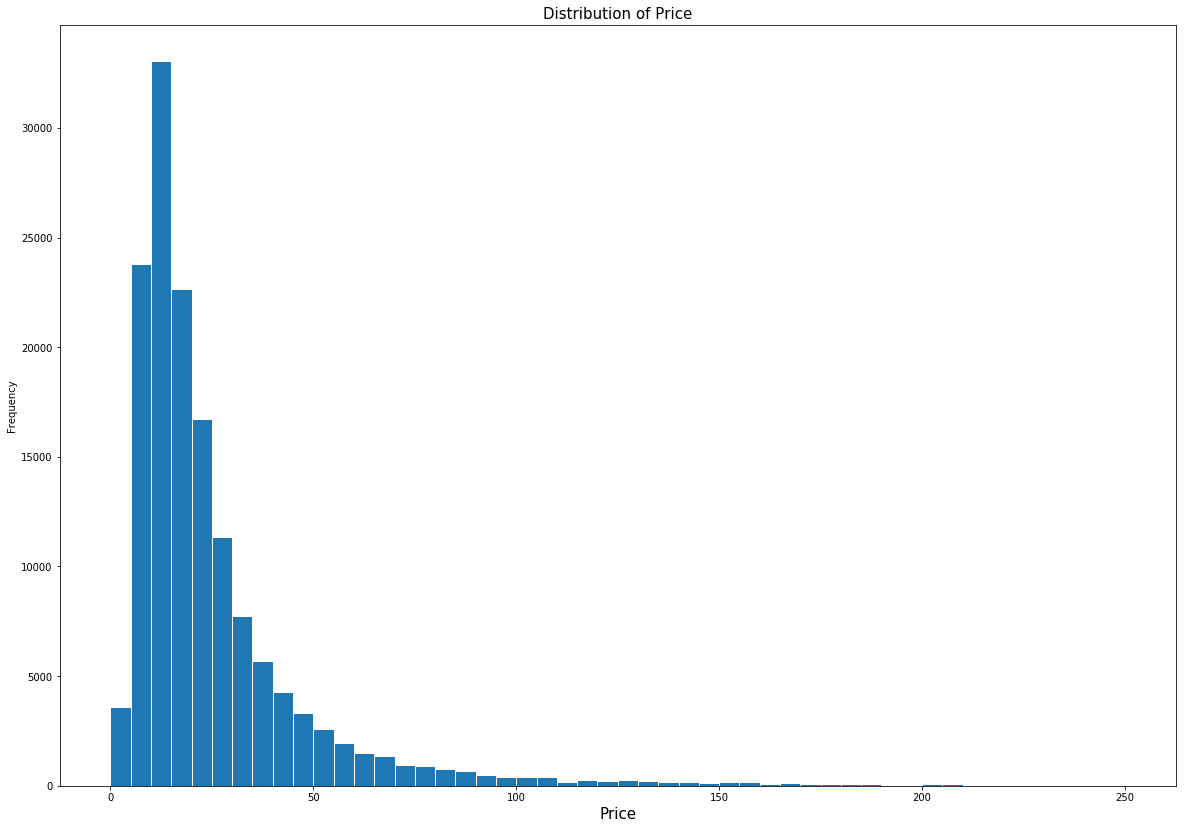

In [15]:
### Distribution of Price
plt.figure(figsize =(20,14))
(train['price']).plot.hist(bins=50, edgecolor='white', range=[0,250])
plt.xlabel('Price', fontsize=15)
plt.title('Distribution of Price', fontsize=15)

We can see that the price distribution is highly skewed. So we will apply log transformation to fix this skewness problem. Log transformation will convert its distribution to normal distribution.

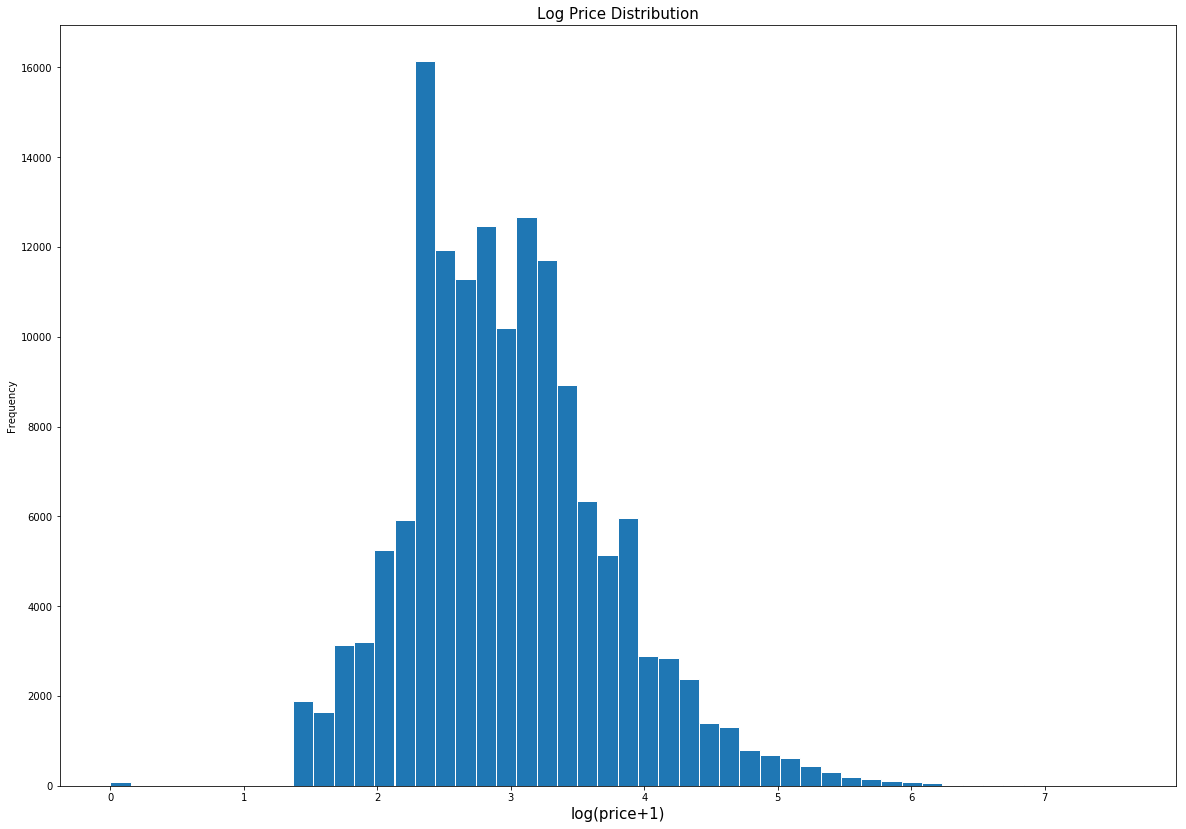

In [17]:
plt.figure(figsize=(20,14))
np.log(train['price']+1).plot.hist(bins=50, edgecolor ='white')
plt.xlabel('log(price+1)', fontsize =15)
plt.title('Log Price Distribution', fontsize=15)
plt.show()

### Eliminating products which have price 0

In [18]:
train[train['price']==0]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
17,900334,Victorias Secret love is heavenly parfum,2,Beauty/Fragrance/Women,Victoria's Secret,0.0,0,•brand new out of box •unused •2.5 fl oz •reta...
2288,722243,Seven7 Luxe Denim Capris Size 20,3,"Women/Jeans/Capri, Cropped",Seven7,0.0,0,"Seven7 Luxe Denim Capris Size 20. Gently worn,..."
3449,879981,Umgee Dress,2,Women/Dresses/Knee-Length,Unknown,0.0,0,Super cute for fall and during the holidays!
4005,1446187,Handcrafted Jadeite Frogs and Crystals,2,Women/Jewelry/Bracelets,Unknown,0.0,0,Handcrafted Green Jadeite Carved Good Luck Fro...
8341,542457,New York Yankee Baseball Jersey,2,Sports & Outdoors/Fan Shop/MLB,Unknown,0.0,0,Bernie William Cool-base Jersey Condition 10/1...
9089,503127,Wardrobe Bag,1,Home/Storage & Organization/Clothing & Closet ...,Unknown,0.0,0,"Stores 15-20 dresses,Suits, Coats and long Gar..."
10317,1256388,Nike Kyrie 2,2,Men/Shoes/Athletic,Nike,0.0,0,"Nike Kyrie 2, worn once indoor, at a basketbal..."
11035,1268686,Royal Blue Full Zip Up NWT,1,Women/Athletic Apparel/Jackets,Danskin,0.0,0,Dri-more tech full zip long sleeve performance...
11220,1385276,Contour Profusion,3,Beauty/Makeup/Makeup Palettes,Unknown,0.0,0,Contour kit. Only two of the colors used once ...
14943,859426,Pennylynn,1,Beauty/Makeup/Eyes,Milani,0.0,1,You will receive 1 NEW MILANI LIQUID LIKE EYE ...


In [19]:
train[train['price']==0].shape

(87, 8)

 We have 87 items with price of $0. Let's eliminate them as it is a error.

In [21]:
train = train[train['price']!=0]
train.shape

(148167, 8)

### Analyze distribution of shipping 

In [22]:
train['shipping'].value_counts() / len(train)

0    0.553052
1    0.446948
Name: shipping, dtype: float64

### Distribution of price based on shipping type

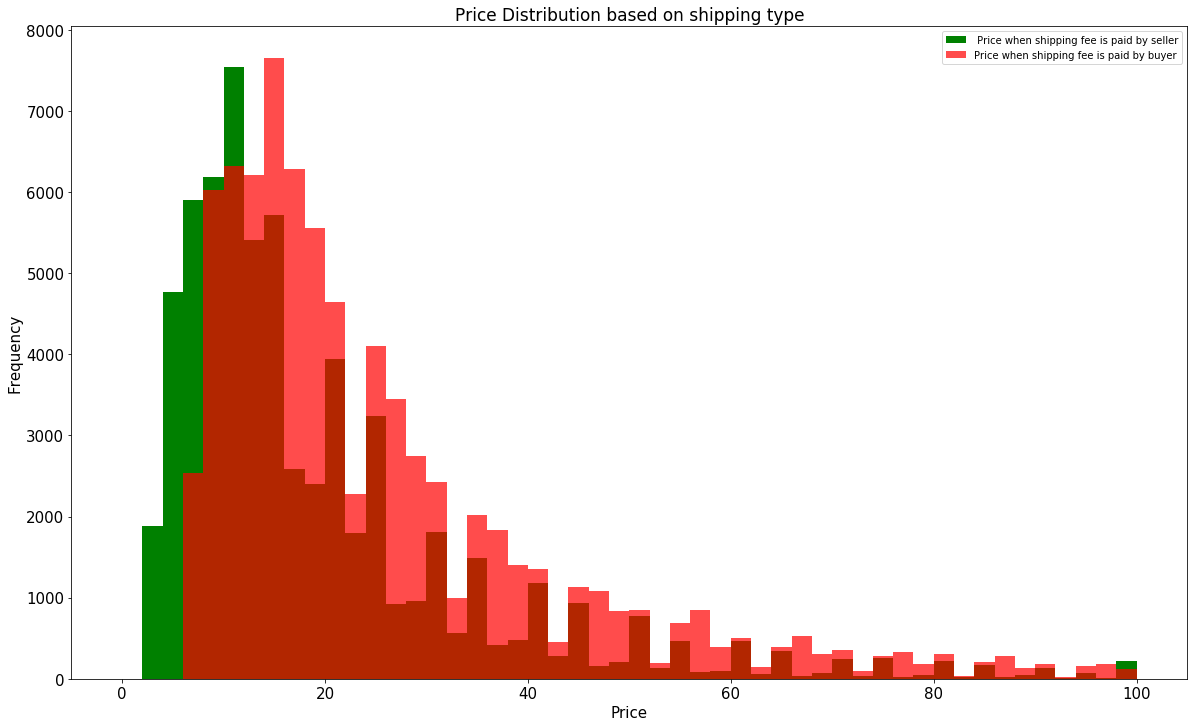

In [23]:
shipping_fee_by_buyer = train.loc[train['shipping']==0, 'price']
shipping_fee_by_seller = train.loc[train['shipping']==1, 'price']

fig, ax = plt.subplots(figsize= (20,12))

ax.hist(shipping_fee_by_seller, color='green', alpha=1.0, bins=50, range=[0,100], label =' Price when shipping fee is paid by seller')
ax.hist(shipping_fee_by_buyer, color ='red', alpha =0.7, bins=50, range=[0,100], label='Price when shipping fee is paid by buyer')

plt.xlabel('Price', fontsize= 15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Price Distribution based on shipping type", fontsize =17)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

From the above visualization, we can conclude that price of the product is greater when seller pays shipping costs.

### Mean Price for Shipping Type

In [24]:
print('The mean price is ${}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping')
print('The mean price is ${}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The mean price is $22.62 if seller pays shipping
The mean price is $30.24 if buyer pays shipping


## Analyze the top 10 categories

In [25]:
top_10_cat = train['category_name'].value_counts()[:10].reset_index()
top_10_cat

,index,category_name
0,"Women/Athletic Apparel/Pants, Tights, Leggings",6026
1,Women/Tops & Blouses/T-Shirts,4625
2,Beauty/Makeup/Face,3386
3,Beauty/Makeup/Lips,3020
4,Electronics/Video Games & Consoles/Games,2715
5,Beauty/Makeup/Eyes,2505
6,"Electronics/Cell Phones & Accessories/Cases, C...",2434
7,Women/Underwear/Bras,2078
8,"Women/Tops & Blouses/Tank, Cami",2047
9,"Women/Dresses/Above Knee, Mini",2047


In [26]:
### Distribution of top 10 categories

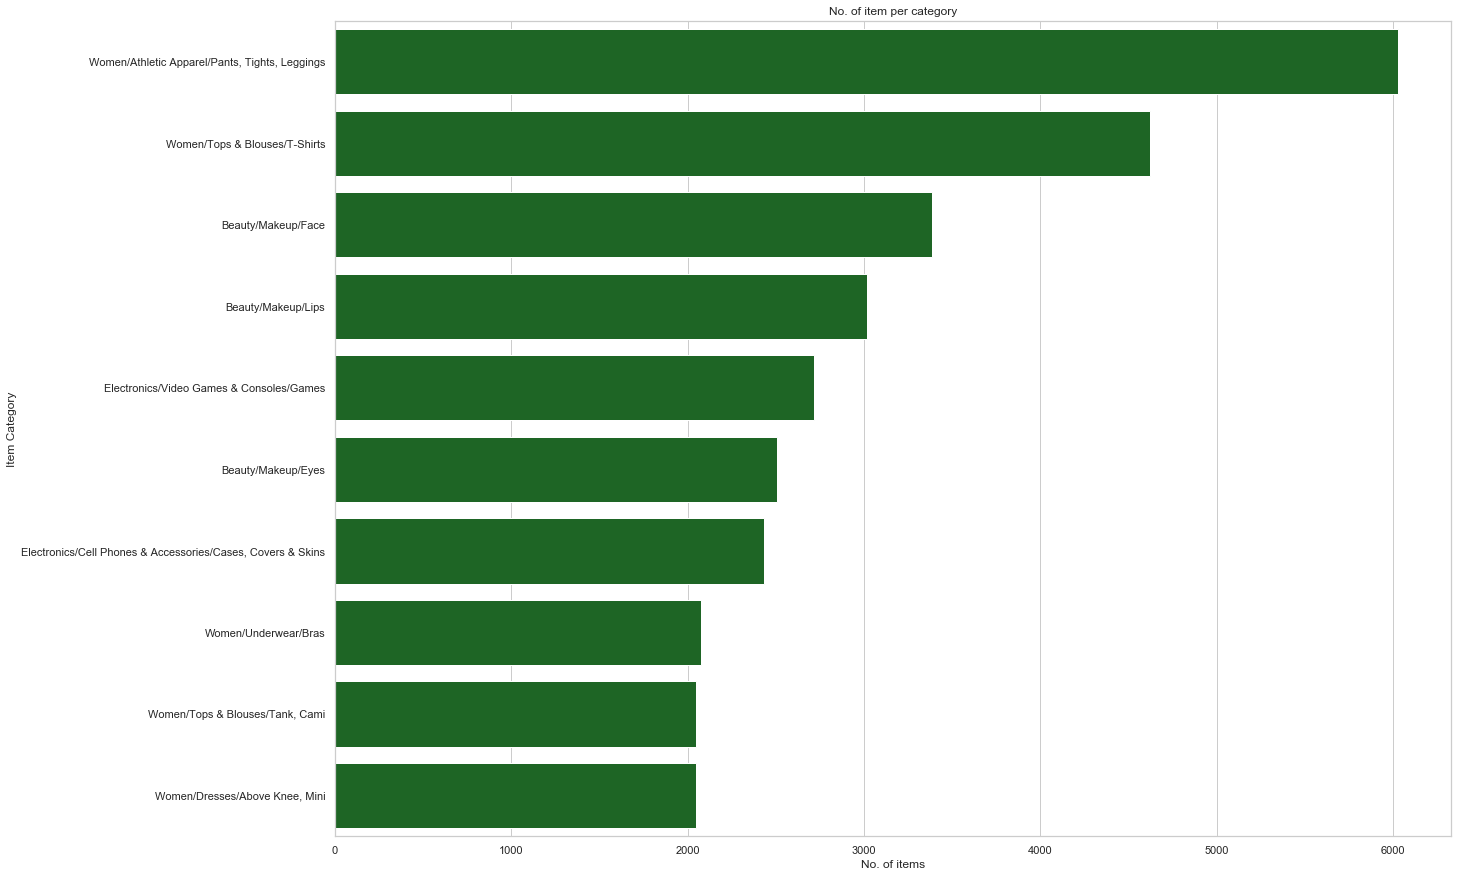

In [27]:
top_10_cat = train['category_name'].value_counts()[:10].reset_index()
sns.set(style='whitegrid')

### Initializing the figure and setting the figure parameters
f, ax = plt.subplots(figsize=(20,15))
sns.set_color_codes("dark")
sns.barplot(x='category_name', y='index', data=top_10_cat, label=' No. of items', color='g')
ax.set(ylabel= "Item Category", title = "No. of item per category", xlabel="No. of items")
plt.show()

## Implementing Feature Engineering

There's a format in the category feature of this training dataset i.e. **Root Category/Category/Subcategory**. Therefore, we will split the category and save each of them in a separate column.

In [29]:
### Creating new category features
def convert_category_name(category_name):
    try:
        main, sub1, sub2 =category_name.split('/')
        return main, sub1, sub2
    except:
        return 'Other', 'Other', 'Other'

In [30]:
train['category_main'], train['category_sub1'], train['category_sub2']= zip(*train['category_name'].apply(convert_category_name)) 
cat_train = train[['category_main', 'category_sub1', 'category_sub2','price']]
cat_train.head()

C:\Users\Ojas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,category_main,category_sub1,category_sub2,price
0,Women,Tops & Blouses,"Tank, Cami",14.0
1,Kids,Toys,Arts & Crafts,27.0
2,Women,Jeans,"Slim, Skinny",19.0
3,Men,Shoes,Athletic,53.0
4,Women,Jewelry,Earrings,18.0


## Top 10 Main Categories

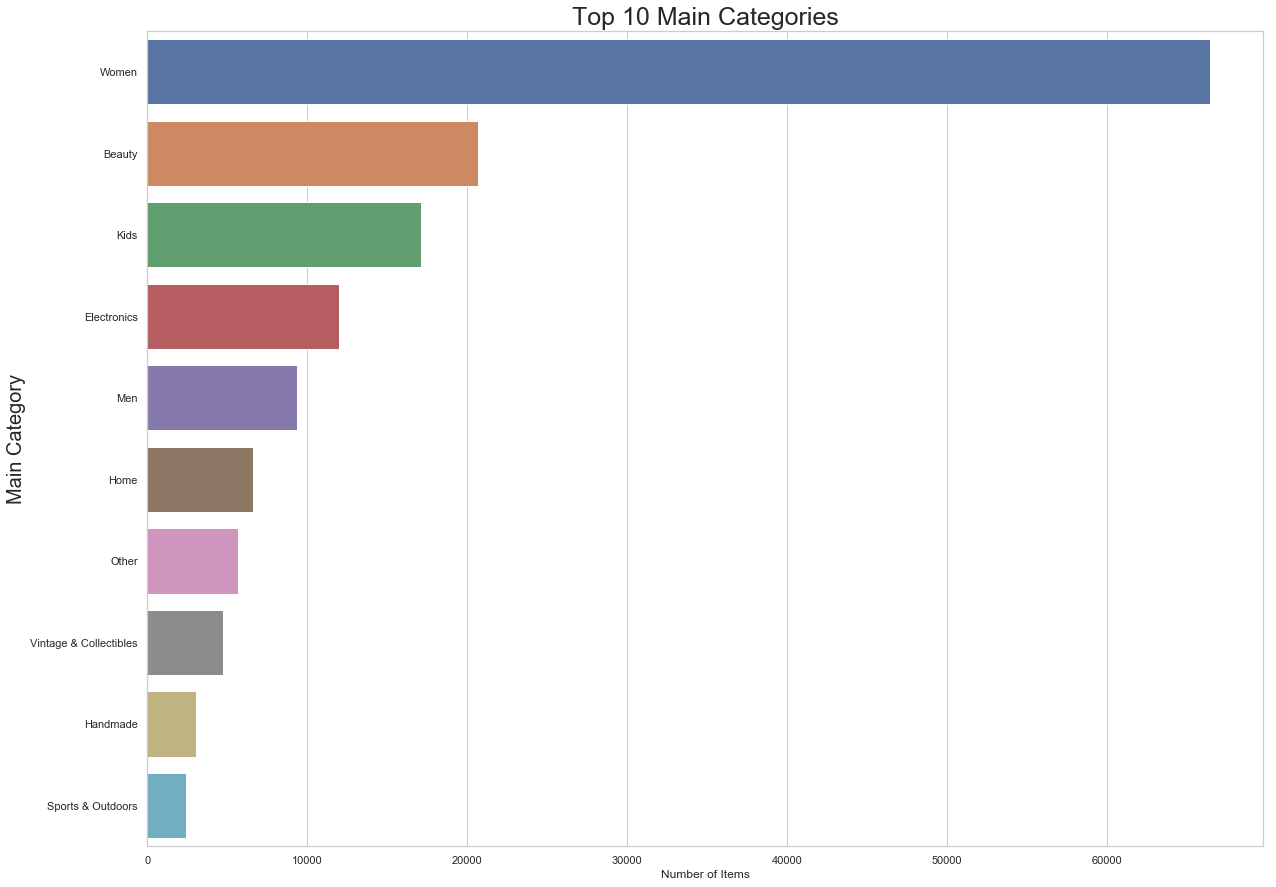

In [31]:
plt.figure(figsize=(20,15))
sns.countplot(y = train['category_main'], order = train['category_main'].value_counts().index, orient = 'v')
plt.title('Top 10 Main Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items')
plt.show()

Majority of the items are women and beauty products . Its interesting because it allows us to know who the users are and the company can perform some sort of targeted marketing. 

## Ratio of Main Categories

In [33]:
train['category_main'].value_counts()/len(train)

Women                     0.448629
Beauty                    0.139552
Kids                      0.115532
Electronics               0.081050
Men                       0.063185
Home                      0.044673
Other                     0.038274
Vintage & Collectibles    0.032031
Handmade                  0.020727
Sports & Outdoors         0.016346
Name: category_main, dtype: float64

## Analyzing Brands

In [34]:
#Distinct Brand Names
train['brand_name'].nunique()

2326

There are about 2326 distinct brands

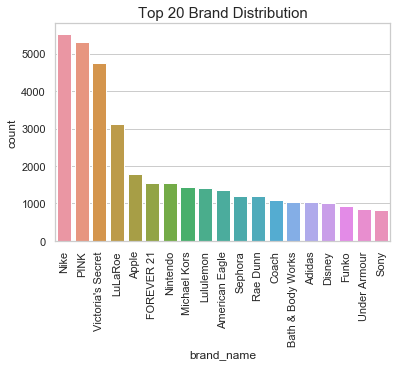

In [36]:
# Top 20 Brands
top_20_brands = train['brand_name'].value_counts()[1:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=top_20_brands)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()

## Expensive Top 20 Brands

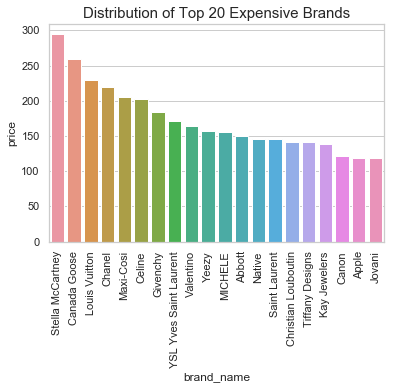

In [37]:
top_20_exp_brand = pd.DataFrame(train.groupby(['brand_name'],as_index=True).std().price.sort_values(ascending=False)[0:20]).reset_index()
ax = sns.barplot(x="brand_name", y="price", data=top_20_exp_brand)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Distribution of Top 20 Expensive Brands', fontsize=15)
plt.show()

## Analyzing relation between Length of description and Price

In [38]:
train['item_description'] = train['item_description'].astype(str)
des = train[['name','item_description', 'price']]
des['count']= des['item_description'].apply(lambda x : len(str(x)))
des.head()


C:\Users\Ojas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ojas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,name,item_description,price,count
0,Brandy Melville Black Crop Top,Super cute great conditions!!,14.0,29
1,Copic Markers Sketch,Brand new markers. Retail for [rm] each. Selli...,27.0,128
2,American Eagle Outfitter Jeans,American Eagle Outfitter Jeans. Size 2.,19.0,39
3,"KD 8 ""aunt pearls""",Very good condition. Accepting offers. Want a ...,53.0,122
4,Chanel earrings quilted double cc style,Great pair of earrings new never worn Free shi...,18.0,53


In [39]:
df = des.groupby('count')['price'].mean().reset_index()
df.head()

,count,price
0,1,19.977778
1,2,24.276923
2,3,22.529874
3,4,23.466667
4,5,27.526946


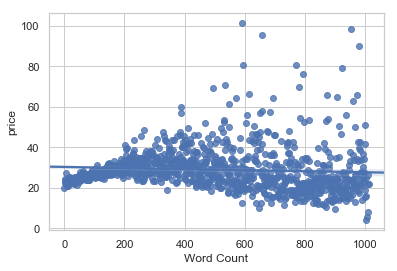

In [40]:
sns.regplot(x=df['count'], y=df['price'])
plt.xlabel("Word Count")
plt.show()

# Processing Text 

We will perform the following techniques to normalize the text :
<ul>
<li>Eliminating Punctuations</li>
<li>Removing Stop words</li>
<li>Converting words to lowercase</li>
<li>Stemming the words</li></ul>

### List of Punctuations

In [42]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [43]:
# Creating a list for replacing punctuations
punc_symbols = []
for symbol in punctuation:
    punc_symbols.append((symbol,''))
    
print(punc_symbols)

[('!', ''), ('"', ''), ('#', ''), ('$', ''), ('%', ''), ('&', ''), ("'", ''), ('(', ''), (')', ''), ('*', ''), ('+', ''), (',', ''), ('-', ''), ('.', ''), ('/', ''), (':', ''), (';', ''), ('<', ''), ('=', ''), ('>', ''), ('?', ''), ('@', ''), ('[', ''), ('\\', ''), (']', ''), ('^', ''), ('_', ''), ('`', ''), ('{', ''), ('|', ''), ('}', ''), ('~', '')]


### List of Stop Words

In [44]:
# Observing list of stop words
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Functions for normalizing words

In [45]:
import string

#Creating function for eliminating punctuations
def remove_punc(sentence:str) -> str:
    return sentence.translate(str.maketrans('','', string.punctuation))

# Creating function for removing stop words
def remove_stop_words(x):
    x= ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Creating function for converting words to lowercase
def lowercase(x):
    return x.lower()

### Applying Normalizing Functions

In [46]:
#Stemming words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
train['item_description'] = train['item_description'].apply(porter.stem)
train['item_description'] = train['item_description'].apply(remove_punc)
train['item_description'] = train['item_description'].apply(remove_stop_words)
train['item_description'] = train['item_description'].apply(lowercase)

train['name'] = train['name'].apply(remove_punc)
train['name'] = train['name'].apply(remove_stop_words)
train['name'] = train['name'].apply(lowercase)

C:\Users\Ojas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Ojas\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Ojas\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

## Text Feature Extraction


**Feature Pre-Processing:** Sometimes you can't just fit a dataset into your model and expect good results. Each type of feature has their own way of preprocessing. Choice of preprocessing method also depends on the model we are trying to use.</li>

Since we're working with Text Features, we're going to do a lot of vectorization:

**Tokenization:** split each text into words (bag of words model)
**Stemming:** removing word inflections (getting the root word)
**Vectorization:** reducing text into a vector with different types of frequencies for each word (Count Values or TF-IDF Values)
**Bag of Words:** When we vectorize these words, we're doing creating a feature for each word. Also known as, Bag of Words. We lose word ordering

Solution: To preserve some ordering, we can introduce **n-grams** into our vectorization of words (problem: too many features),one way to reduce dimensions of n-grams is to remove stop words (a, the, is)
**Stop words:** we can remove these words becaues they are just there for grammatical structure with little to no meaning
n-gram with smaller frequencies can highlight and capture important parts of a document/text. This preserves local ordering and can improve model performance.

In [47]:
# Observing the normalized ite description feature
train['item_description'][115:125]

116    size 1 flats velcro closure good condition asi...
117                                        brand new tag
118    ✨lowest final sale brand new never used cut ta...
119    excellent condition size medium dgk freshman v...
120    brand new never opened contains large punch 7 ...
121    glow moon glow stars 1 foot moon 40 brightest ...
122           four new pop sockets never used separate w
123    tar wars plastic yoda holiday 10 light set  in...
124                          vs basically full warm cozi
125    mint condition jordans size 25y usually fit ki...
Name: item_description, dtype: object

In [48]:
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
text = train['item_description'][120]
tokens = word_tokenize(text)
print(tokens)

['brand', 'new', 'never', 'opened', 'contains', 'large', 'punch', '7', 'foam', 'stamps', 'hours', 'fun', 'creativity', 'scrapper']


### Word Frequency Weights
Each word in our feature space can have different frequency weights

Frequency Weight
TF-IDF Weight
Binary
CountVectorizer: Returns an encoded vector with integer count for each word

TF-IDF(min_df, max_df, n-gram): Returns encoded vector with weighted count for each word (utilizes the word in the document in corresponsdence to the whole corpus, to keep it short, more emphasis on the rarity of a word). This is good because we want to find frequent terms from that document that isn't so frequent within the whole document corpus.

LabelBinarizer: Get's all the word and assigns it to its own column. 0 means it's there and 1 means not (example with brand names)

Why are we doing this again?: Because some Machine Learning models don't recognize text as well. You're going to have to convert it into numbers

In [49]:
# Observing features
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_main,category_sub1,category_sub2
0,15235,brandy melville black crop top,3,"Women/Tops & Blouses/Tank, Cami",Brandy Melville,14.0,0,super cute great conditions,Women,Tops & Blouses,"Tank, Cami"
1,358073,copic markers sketch,1,Kids/Toys/Arts & Crafts,Unknown,27.0,1,brand new markers retail rm selling large port...,Kids,Toys,Arts & Crafts
2,969430,american eagle outfitter jeans,3,"Women/Jeans/Slim, Skinny",American Eagle,19.0,0,american eagle outfitter jeans size 2,Women,Jeans,"Slim, Skinny"
3,291315,kd 8 aunt pearls,3,Men/Shoes/Athletic,Nike,53.0,0,good condition accepting offers want quick sal...,Men,Shoes,Athletic
4,1462571,chanel earrings quilted double cc style,1,Women/Jewelry/Earrings,Chanel,18.0,1,great pair earrings new never worn free shipping,Women,Jewelry,Earrings


### Encoding Categorical Variables
name
brand_name
category_main, category_sub1, category_sub2
item_description
shipping
item_condition_id

## Count Vectorizer

In [50]:
cv= CountVectorizer(min_df=10)
x_name = cv.fit_transform(train['name'])
x_cat_main = cv.fit_transform(train['category_main'])
x_cat_sub1 = cv.fit_transform(train['category_sub1'])
x_cat_sub2 = cv.fit_transform(train['category_sub2'])

In [51]:
print("Shape of Item Name: "+ str(x_name.shape))
print("Shape of Category Main:" + str(x_cat_main.shape))
print("Shape of Category Sub1:" + str(x_cat_sub1.shape))
print("Shape of Category Sub2:" + str(x_cat_sub2.shape))

Shape of Item Name: (148167, 5283)
Shape of Category Main:(148167, 12)
Shape of Category Sub1:(148167, 132)
Shape of Category Sub2:(148167, 585)


## Label Binarizer

In [52]:
# Applying Label Binarizer to "brand_name" feature
lab= LabelBinarizer(sparse_output=True)
x_brand = lab.fit_transform(train['brand_name'])
print("Shape of Brand Name: "+ str(x_brand.shape))

Shape of Brand Name: (148167, 2326)


## Get Dummies

In [53]:
# Applying get_dummies to "item_condition_id" and "shipping" and then converting it into a CSR Matrix
x_dummies = csr_matrix(pd.get_dummies(train[['item_condition_id', 'shipping']], sparse =True).values)

## TF-IDF

**Main Goal:** Measure hwo important a word or phrase is within a collection of documents. It essentially weigh down terms that appear frequently and scale up unique terms.

TF Term Frequency how often a term occurs

IDF Inverse Document Frequency how important a term is

**Important Parameters:**
ngram_range
stop_words
lowercase
max_df - max threshold that will ignore a term that has a document frequency higher than the threshold
min_df - min threshold that will ignore a term that has a document frequency lower than the threshold
max_features - gets the assigned amount of features with highest amount of term frequencies (scores)


In [54]:
# Perform a TFIDF Transformation of the item description with the top 55000 features and has an n-gram range of 1-2
tf = TfidfVectorizer(max_features = 55000, ngram_range=(1,2), stop_words ='english')
x_description= tf.fit_transform(train['item_description'])

In [55]:
print("Shape of Item Description: " + str(x_description.shape))

Shape of Item Description: (148167, 55000)


### Observing TF-IDF Weights

In [56]:
# Creating a dictionary which will map the tokens to their tf-idf values
tfidf= dict(zip(tf.get_feature_names(), tf.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf),orient= 'index')
tfidf.columns = ['tfidif']


In [57]:
#Lowest TFIDF scores
tfidf.sort_values(by=['tfidif'],ascending=True).head(10)

,tfidif
new,2.190640
size,2.346105
brand,2.754934
brand new,2.879822
condition,2.920942
free,2.936593
worn,3.099236
used,3.219031
shipping,3.223760
great,3.342503


In [58]:
#Highest TFIDF scores
tfidf.sort_values(by=['tfidif'],ascending=False).head(10)

,tfidif
cruz amethyst,12.212955
vera cruz,12.212955
hero5 black,12.212955
slime1,12.212955
spirit link,12.212955
mini jar,12.212955
cupti,12.212955
jordan jordan,12.212955
camaro,12.212955
rm bangles,12.212955


## Combining all features into one merge


In [59]:
comb_merge= hstack((x_dummies, x_description, x_brand, x_name,x_cat_main, x_cat_sub1, x_cat_sub2)).tocsr()

In [60]:
comb_merge.shape

(148167, 63340)

### Target Variable in different dataframe


In [61]:
target = np.log1p(train['price'])

In [62]:
# Importing Libraries
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.linear_model import Ridge

In [63]:
train['category_name'] = train['category_name'].astype(str)
train['brand_name'] = train['brand_name'].astype(str)
train['shipping'] = train['shipping'].astype(str)
train['item_condition_id'] = train['item_condition_id'].astype(str)


C:\Users\Ojas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ojas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ojas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

In [64]:

from sklearn.decomposition import LatentDirichletAllocation

# Making changes to the countvectorizer function
cvec = CountVectorizer(max_features=55000, stop_words ='english', lowercase=True)
# Fitting to the dataset4
cvz = cvec.fit_transform(train['item_description'])
# Initializing LDA with 10 topics
lda_model = LatentDirichletAllocation(n_topics=10,random_state=42)

# Fitting to the CountVectorizer Transformation
x_topics = lda_model.fit_transform(cvz) 

# Defining Variables
n_top_words = 10
topic_summaries = []

# Getting the topic words
topic_word = lda_model.components_

# Getting the vocabulary from the text features
vocab = cvec.get_feature_names()

# Displaying the topic models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'. format(i, ' | '.join(topic_words)))

C:\Users\Ojas\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0: new | price | rm | brand | shipping | free | firm | ship | oz | box
Topic 1: brush | skin | rm | water | makeup | card | set | face | pink | cards
Topic 2: condition | free | good | size | great | home | smoke | used | bundle | excellent
Topic 3: new | shipping | rm | free | bundle | brand | items | price | color | save
Topic 4: used | silver | great | gold | box | gift | necklace | hair | ring | use
Topic 5: pop | use | new | book | car | lashes | bluetooth | phone | blue | time
Topic 6: size | worn | small | black | medium | new | dress | fit | large | cute
Topic 7: size | new | condition | pink | worn | black | secret | bag | used | brand
Topic 8: new | brand | tags | bra | worn | leggings | size | tag | lularoe | item
Topic 9: description | iphone | case | plus | phone | new | works | charger | comes | screen


## Analyzing Item Description with Eli5

In [65]:
# Defining RMSLE Cross Validation Function
def rmsle_cv(model):
    kf= KFold(shuffle=True, random_state=42).get_n_splits(train['item_description'])
    rmse= np.sqrt(-cross_val_score(model, train['item_description'], target, scoring ='neg_mean_squared_error', cv= kf))
    return(rmse.mean())

## Creating Baseline Model with CountVectorizer

In [66]:
from sklearn.linear_model import Ridge

vec= CountVectorizer()
rid= Ridge(random_state=42)
pipe = make_pipeline(vec,rid)
pipe.fit(train['item_description'], target)

cv_rmsle = rmsle_cv(pipe)
print("The Validation Score is : " + str(cv_rmsle))

C:\Users\Ojas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is : 0.6619305532716365


In [67]:
#pip install eli5

In [68]:
import eli5
eli5.show_weights(pipe, vec=vec, top=100, feature_filter=lambda x: x != '<BIAS>') 

Weight?,Feature
+1.348,deadstock
+1.052,substitut
+0.973,128gb
+0.893,1855mm
+0.841,harlow
+0.833,hmu
+0.829,ptinr
+0.797,v2
+0.795,hamilton
+0.794,penguala


In [69]:
eli5.show_prediction(rid, doc=train['item_description'][1297], vec=vec)

## Baseline Model with CountVectorizer and Stopwords

In [70]:
vec = CountVectorizer(stop_words='english')
rid = Ridge(random_state=42)
pipe = make_pipeline(vec, rid)
pipe.fit(train['item_description'], target)

cv_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(cv_sw_rmsle))

C:\Users\Ojas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.661732527429027


In [71]:
eli5.show_prediction(rid, doc=train['item_description'][1297], vec=vec)

## Baseline Model with TF-IDF

In [72]:
vec = TfidfVectorizer()
rid = Ridge(random_state=42)
pipe = make_pipeline(vec, rid)
pipe.fit(train['item_description'], target)

tfidf_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_rmsle))

C:\Users\Ojas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6209796368107251


In [73]:
eli5.show_prediction(rid, doc=train['item_description'][1297], vec=vec)

## Baseline Model with TFIDF and Stopwords

In [74]:
vec = TfidfVectorizer(stop_words='english')
rid = Ridge(random_state=42)
pipe = make_pipeline(vec, rid)
pipe.fit(train['item_description'], target)

tfidf_sw_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_rmsle))

C:\Users\Ojas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.621483350115664


In [75]:
eli5.show_prediction(rid, doc=train['item_description'][1297], vec=vec)

## Baseline Model with TF-IDF, Stop words and N-Grams 

In [76]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
rid = Ridge(random_state=42)
pipe = make_pipeline(vec, rid)
pipe.fit(train['item_description'], target)

tfidf_sw_ng_rmsle = rmsle_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_ng_rmsle))

C:\Users\Ojas\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


The Validation Score is: 0.6102325715303093


In [77]:
eli5.show_prediction(rid, doc=train['item_description'][1297], vec=vec)

## Summary of RMSLE

TF-IDF + Stop Words + N-Grams will probably work ultimately

In [78]:
print ("RMSLE Score: " + str(cv_rmsle) + " | CountVectorizer")
print ("RMSLE Score: " + str(cv_sw_rmsle) + " | CountVectorizer | Stop Words")
print ("RMSLE Score: " + str(tfidf_rmsle) + " | TF-IDF")
print ("RMSLE Score: " + str(tfidf_sw_rmsle) + " | TF-IDF | Stop Words")
print ("RMSLE Score: " + str(tfidf_sw_ng_rmsle) + " | TF-IDF | Stop Words | N-Grams")

RMSLE Score: 0.6619305532716365 | CountVectorizer
RMSLE Score: 0.661732527429027 | CountVectorizer | Stop Words
RMSLE Score: 0.6209796368107251 | TF-IDF
RMSLE Score: 0.621483350115664 | TF-IDF | Stop Words
RMSLE Score: 0.6102325715303093 | TF-IDF | Stop Words | N-Grams


## To be continued ...